In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

## 1. Прочитаем данные

In [2]:
data = pd.read_csv('owid-covid-data.csv')
data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293538,ZWE,Africa,Zimbabwe,2023-03-03,264127.0,0.0,11.571,5668.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
293539,ZWE,Africa,Zimbabwe,2023-03-04,264127.0,0.0,4.571,5668.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
293540,ZWE,Africa,Zimbabwe,2023-03-05,264127.0,0.0,2.714,5668.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
293541,ZWE,Africa,Zimbabwe,2023-03-06,264127.0,0.0,0.000,5668.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN


In [3]:
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [4]:
[x for x in data.location.unique() if 'rus' in x.lower()]

['Belarus', 'Cyprus', 'Northern Cyprus', 'Russia']

In [5]:
data_r = data[(data.location == 'Russia') & (data.date >= '2020-03-03') & (data.date <= '2020-12-31')]
data_r = data_r[['date', 'new_cases', 'total_cases']] \
    .replace({'new_cases': 0}, 1).dropna().reset_index(drop=True)

data_r['day'] = data_r.index + 1
data_r['new_cases'] = data_r['new_cases'].apply(int)
data_r['total_cases'] = data_r['new_cases'].cumsum()
data_r

,date,new_cases,total_cases,day
0,2020-03-03,1,1,1
1,2020-03-04,1,2,2
2,2020-03-05,1,3,3
3,2020-03-06,1,4,4
4,2020-03-07,1,5,5
...,...,...,...,...
299,2020-12-27,28284,3050257,300
300,2020-12-28,27787,3078044,301
301,2020-12-29,27002,3105046,302
302,2020-12-30,26513,3131559,303


In [6]:
train = data_r[:50].copy()
test = data_r[50:].copy()

## 2.a

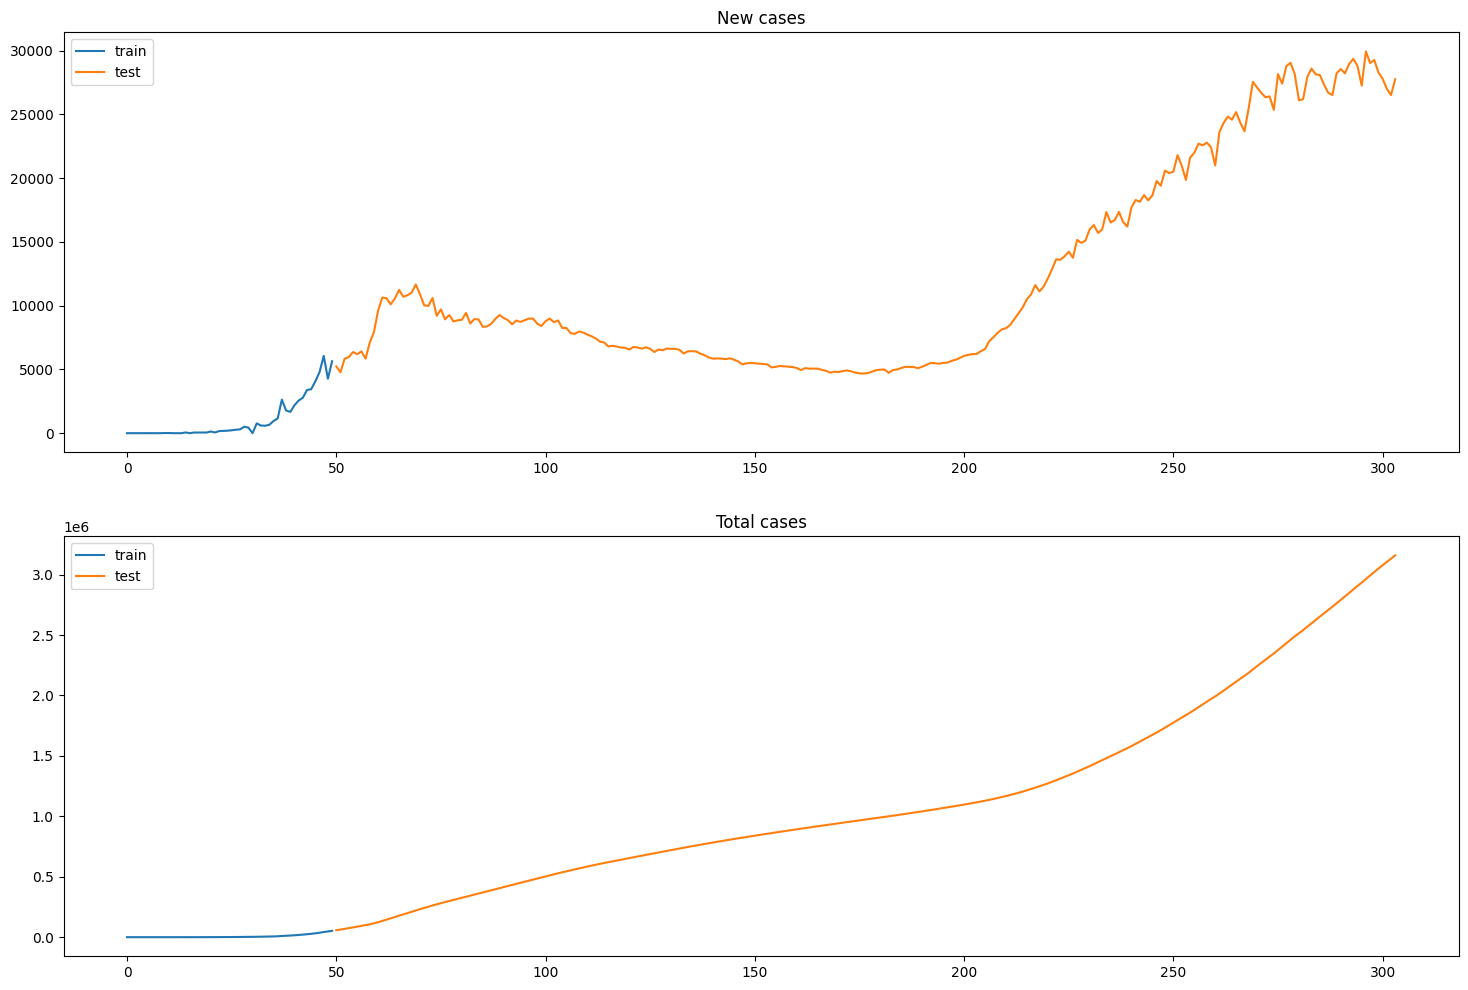

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

ax = axes[0]
ax.set_title('New cases')
ax.plot(train['new_cases'], label='train')
ax.plot(test['new_cases'], label='test')
ax.legend()

ax = axes[1]
ax.set_title('Total cases')
ax.plot(train['total_cases'], label='train')
ax.plot(test['total_cases'], label='test')
ax.legend()

plt.show()

In [8]:
model = LinearRegression()
model.fit(train[['day']], np.log(train['new_cases']))

print(f'ln(new_cases) = a * (new_cases) + b. a={model.coef_[0]}; b={model.intercept_}')

ln(new_cases) = a * (new_cases) + b. a=0.19995828847940364; b=-0.6059353054631389


In [9]:
class BayesianLinearRegression:
    def __init__(self, mu0, sigma0):
        self.mu0 = mu0
        self.sigma0 = sigma0
        self.mu = mu0
        self.sigma = sigma0
        self.is_fitted = False
    
    def __repr__(self):
        return f'{self.__class__.__name__}(mu0 = {self.mu0}, sigma0 = {self.sigma0})'
    
    def estimate_noise(self, X, y):
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        noise = np.var(y - X @ w)
        return noise
    
    def bayesian_update(self, X, y, noise):
        sigma = np.linalg.inv(self.sigma0) + X.T @ X / noise
        self.sigma = np.linalg.inv(sigma)
        
        mu = np.linalg.inv(self.sigma0) @ self.mu0 + X.T @ y / noise
        self.mu = self.sigma @ mu
    
    def fit(self, X, y):
        X = np.hstack((X, np.ones((len(X), 1))))
        noise = self.estimate_noise(X, y)
        self.bayesian_update(X, y, noise)
        self.is_fitted = True
        return self
    
    def predict(self, X):
        if not self.is_fitted:
            raise NotFittedError
        X = np.hstack((X, np.ones((len(X), 1))))
        return X @ self.mu
    
    def sample_predict(self, X, n):
        if not self.is_fitted:
            raise Exception('Model is not fitted')
        X = np.hstack((X, np.ones((len(X), 1))))
        w_sample = np.random.multivariate_normal(self.mu, self.sigma, n)
        res = []
        for w in w_sample:
            res.append(X @ w)
        return np.array(res)

In [10]:
blr = BayesianLinearRegression(mu0 = np.zeros((2,)), sigma0 = 100 * np.eye(2))
blr.fit(train[['day']], np.log(train['new_cases']))

print(f'ln(new_cases) = a * (new_cases) + b. a={blr.mu[0]}; b={blr.mu[1]}')

ln(new_cases) = a * (new_cases) + b. a=0.19993606861659963; b=-0.6051895576427526


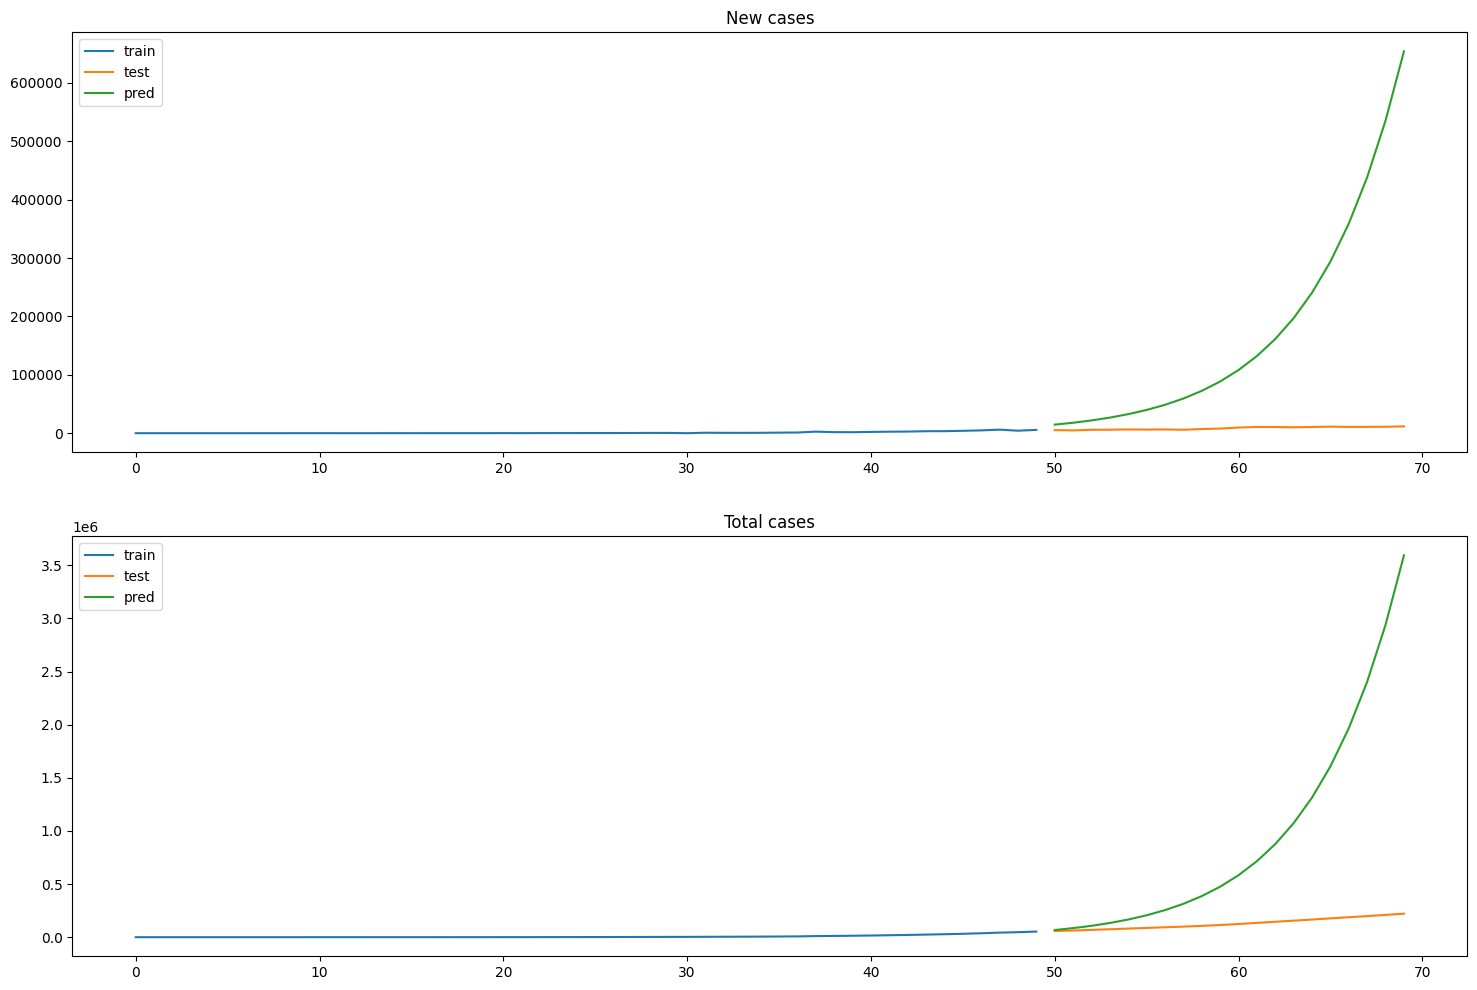

In [11]:
prediction_period = 20

predictions = test[['day']].copy()
predictions['new_cases'] = np.exp(blr.predict(predictions[['day']]))
predictions['total_cases'] = np.cumsum(predictions['new_cases']) + train['total_cases'].iloc[-1]

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

ax = axes[0]
ax.set_title('New cases')
ax.plot(train['new_cases'], label='train')
ax.plot(test[:prediction_period]['new_cases'], label='test')
ax.plot(predictions[:prediction_period]['new_cases'], label='pred')
ax.legend()

ax = axes[1]
ax.set_title('Total cases')
ax.plot(train['total_cases'], label='train')
ax.plot(test[:prediction_period]['total_cases'], label='test')
ax.plot(predictions[:prediction_period]['total_cases'], label='pred')
ax.legend()


plt.show()

## 2.b

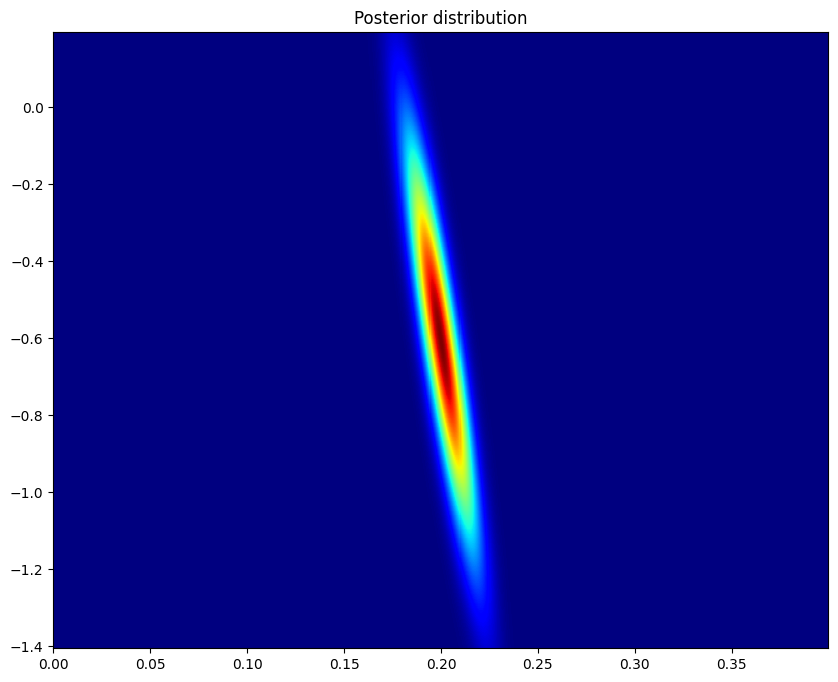

In [12]:
space_size = 750

x_lim = (blr.mu[0] - .2, blr.mu[0] + .2)
y_lim = (blr.mu[1] - .8, blr.mu[1] + .8)

X = np.linspace(*x_lim, space_size)
Y = np.linspace(*y_lim, space_size)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


Z = multivariate_normal.pdf(pos, mean=blr.mu, cov=blr.sigma)

plt.figure(figsize=(10, 8))
plt.title('Posterior distribution')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.show()

## 2.c

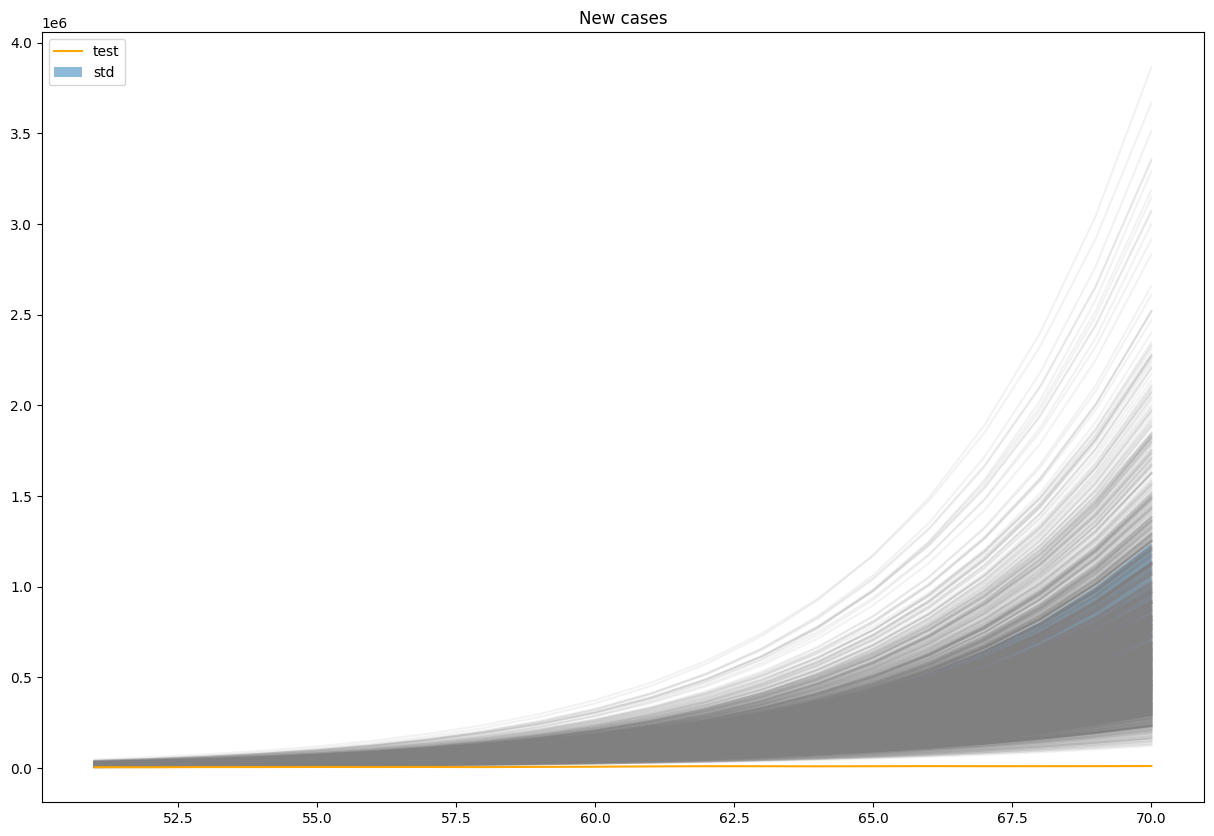

In [13]:
forecast = test[:prediction_period][['day']]
samples = np.exp(blr.sample_predict(forecast, 2000))


plt.figure(figsize=(15, 10))
plt.title("New cases")
for pred in samples:
    plt.plot(forecast, pred, alpha=.1, color='grey')
plt.plot(forecast, test[:prediction_period]['new_cases'].values, label='test', color='orange')

lb = np.mean(samples, axis=0) - np.std(samples, axis=0) 
ub = np.mean(samples, axis=0) + np.std(samples, axis=0)
plt.fill_between(forecast.squeeze(), lb, ub, alpha=.5, label='std')

plt.legend()
plt.show()

In [14]:
print(f'1 мая: {int(predictions[predictions.day == 60].total_cases)}')
print(f'1 июня: {int(predictions[predictions.day == 90].total_cases)}')
print(f'1 сентября: {int(predictions[predictions.day == 180].total_cases)}')

1 мая: 475093
1 июня: 196672252
1 сентября: 12840278735184058


## 3.a

Если кривую общего количества заболевших (у нас это total_cases) представить как сигмоиду, то можно продифференциировав обе части уравнения получить:

$y' = e^{ax^{2} + bx + c}$ \
$ln y' =  ax^{2} + bx + c$

В нашем случае, можно считать что y' равно new_cases.

## 3.b

In [15]:
train.loc[:, 'day^2'] = train['day'] ** 2
test.loc[:, 'day^2'] = test['day'] ** 2

In [16]:
blr = BayesianLinearRegression(mu0=np.zeros(3,), sigma0=100 * np.eye(3))
blr.fit(train[['day', 'day^2']], np.log(train['new_cases']))
print(f'a={blr.mu[0]}; b={blr.mu[1]}; c={blr.mu[2]}')

a=0.26040573720886995; b=-0.0011860267555398873; c=-1.1288182219444778


In [17]:
predictions = test[['day', 'day^2']].copy()
predictions['new_cases'] = np.exp(blr.predict(test[['day', 'day^2']]))
predictions['total_cases'] = np.cumsum(predictions['new_cases']) + train['total_cases'].iloc[-1]

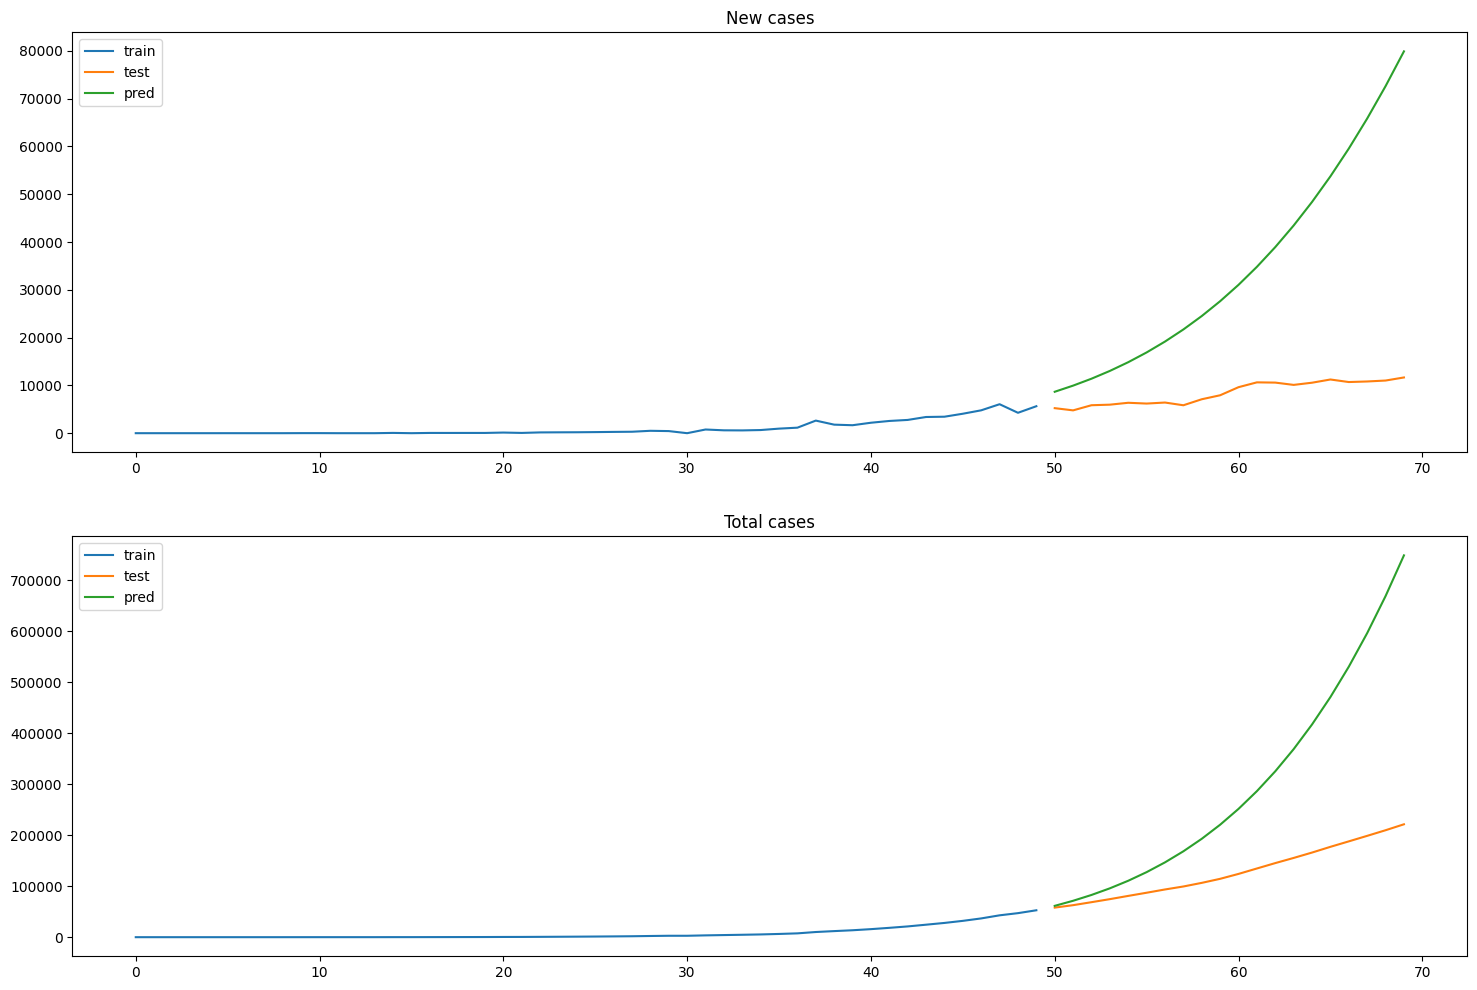

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

ax = axes[0]
ax.set_title('New cases')
ax.plot(train['new_cases'], label='train')
ax.plot(test[:prediction_period]['new_cases'], label='test')
ax.plot(predictions[:prediction_period]['new_cases'], label='pred')
ax.legend()

ax = axes[1]
ax.set_title('Total cases')
ax.plot(train['total_cases'], label='train')
ax.plot(test[:prediction_period]['total_cases'], label='test')
ax.plot(predictions[:prediction_period]['total_cases'], label='pred')
ax.legend()


plt.show()

В данном случае, предсказания уже выглядят ближе к правде. Как минимум имеют один порядок, в отличие от прогнозирования просто экспонентой.

## 3.c

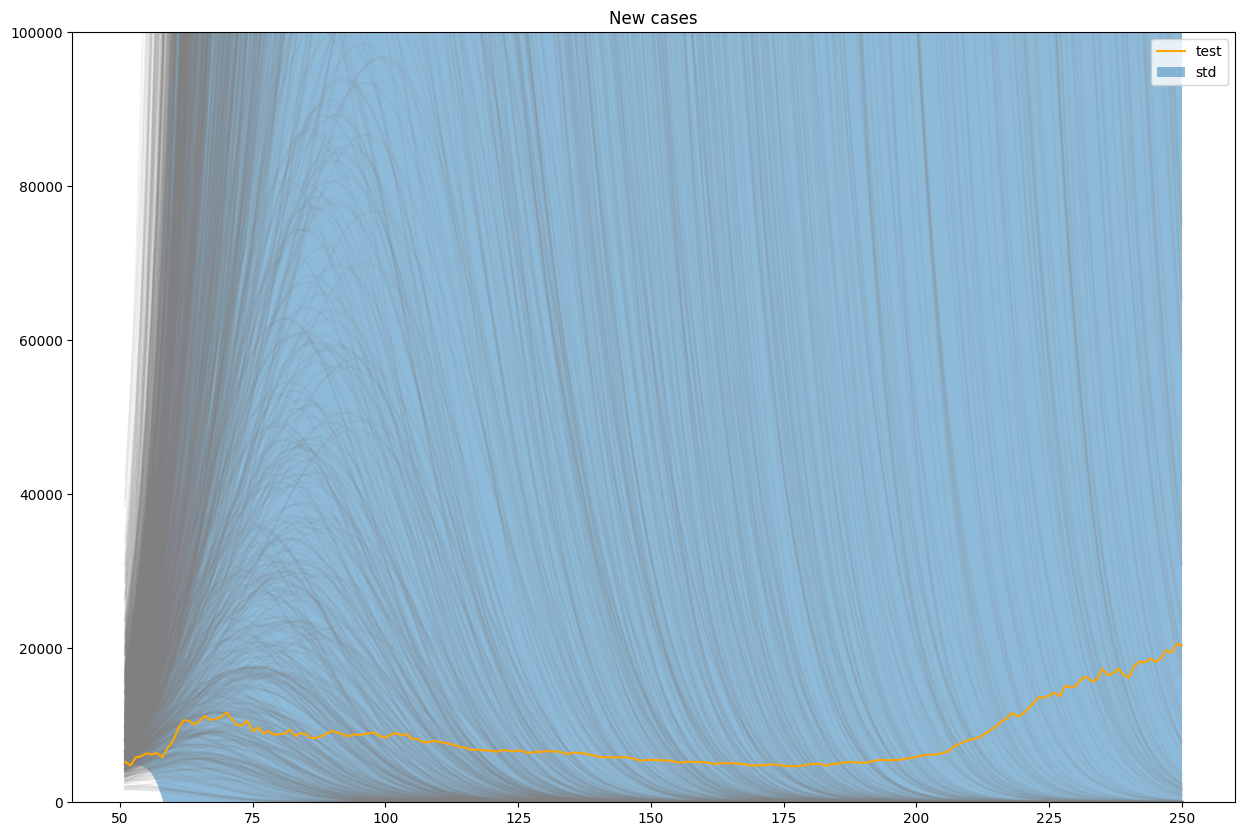

In [19]:
prediction_period = 200
predictions = test[:prediction_period][['day', 'day^2']]
samples = np.exp(blr.sample_predict(predictions, 1000))


plt.figure(figsize=(15, 10))
for pred in samples:
    plt.plot(predictions['day'], pred, alpha=.1, color='grey')
plt.plot(predictions['day'], test[:prediction_period]['new_cases'].values, label='test', color='orange')

lb = np.mean(samples, axis=0) - np.std(samples, axis=0) 
ub = np.mean(samples, axis=0) + np.std(samples, axis=0)
plt.fill_between(predictions['day'], lb, ub, alpha=.5, label='std')

plt.ylim((0, 1e5))
plt.title("New cases")
plt.legend()
plt.show()

In [20]:
total_cases_prediction = samples.sum(axis=1) + train.iloc[-1]['total_cases']

print(f'Пессимистичный сценарий: {int(np.quantile(total_cases_prediction, 0.9))}')
print(f'Оптимистичный сценарий: {int(np.quantile(total_cases_prediction, 0.1))}')

Пессимистичный сценарий: 8033634135159866392576
Оптимистичный сценарий: 405154
